### Sign Language Classification with SVM

In [1]:
# 1. Imports
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from string import ascii_lowercase
import seaborn as sns
from sklearn.model_selection import GridSearchCV

#### Data Loading

In [2]:
DATASET_PATH = "./data/sign_lang_train/images_manipulated/"
CSV_FILE = "labels_manipulated.csv"
IMG_SIZE = (128, 128)
CLASS_NAMES = list(map(str, range(10))) + list(ascii_lowercase)
CLASSES = len(CLASS_NAMES)

In [3]:
import csv
# Utility function

def read_csv(csv_file):
    with open(csv_file, newline='') as f:
        reader = csv.reader(f)
        data = list(reader)
    return data

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils, io
from torchvision.utils import make_grid
from PIL import Image
import matplotlib.pyplot as plt
import os

from string import ascii_lowercase

class SignLangDataset(Dataset):
    """Sign language dataset"""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data = read_csv(os.path.join(root_dir,csv_file))
        self.root_dir = root_dir
        self.transform = transform
        # List of class names in order
        self.class_names = CLASS_NAMES

    def __len__(self):
        """
        Calculates the length of the dataset-
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Returns one sample (dict consisting of an image and its label)
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Read the image and labels
        image_path = os.path.join(self.root_dir, self.data[idx][1])
        
        # Read image as a grayscale PIL image
        image = Image.open(image_path).convert("L")  # 'L' = grayscale mode

        if self.transform:
            image = self.transform(image)

        # The label is the index of the class name in the list ['0','1',...,'9','a','b',...'z']
        # because we should have integer labels in the range 0-35 (for 36 classes)
        label = self.class_names.index(self.data[idx][0])
        
        sample = {'image': image, 'label': label}

        return sample
    
    def show_sample(self, idx: int) -> None:
        """
        Displays a grayscale image with its corresponding class label (0-35).
        
        Args:
            image (numpy.ndarray): The image to display. Shape should be (1, H, W) or (H, W).
            label (int): Integer label in range 0-35.
        """

        sample = self[idx]
        image = sample["image"]
        label_index = sample["label"]
        label = self.class_names[label_index]

        # Flatten channel dimension if needed
        if image.ndim == 3 and image.shape[0] == 1:
            image = image[0] 
        
        plt.imshow(image, cmap="gray")
        plt.title(f"Label: {label}")
        plt.axis("off")
        plt.show()

# Define label mapping
class_names = list(map(str, range(10))) + list(ascii_lowercase)

# Transform Images to 128x128
transform = transforms.Compose([
    transforms.ToTensor(),                   # Converts HxW numpy → CxHxW tensor
    transforms.Resize(IMG_SIZE),             # Resize to 128x128
])

In [5]:
class DuplicatedAugmentedDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, augment_fn, duplicate_factor=2):
        """
        Args:
            base_dataset: Original dataset (e.g. SignLangDataset)
            augment_fn: A torchvision transform to apply to duplicates
            duplicate_factor: How many times to duplicate each original sample
        """
        self.base_dataset = base_dataset
        self.augment_fn = augment_fn
        self.duplicate_factor = duplicate_factor

    def __len__(self):
        return len(self.base_dataset) * self.duplicate_factor

    def __getitem__(self, idx):
        base_idx = idx % len(self.base_dataset)
        original_sample = self.base_dataset[base_idx]

        # Apply augmentation only on the duplicates
        if idx // len(self.base_dataset) > 0:
            augmented_image = self.augment_fn(transforms.ToPILImage()(original_sample['image']))
            image = transforms.ToTensor()(augmented_image)
        else:
            image = original_sample['image']

        return {'image': image, 'label': original_sample['label']}

In [6]:
def dataset_to_numpy(dataset):
    """
    Converts a PyTorch Dataset into NumPy arrays for use with sklearn.
    Assumes images are transformed to shape [1, 128, 128].

    Returns:
        X: np.ndarray of shape [num_samples, 128*128]
        y: np.ndarray of shape [num_samples]
    """
    X = []
    y = []
    for i in range(len(dataset)):
        sample = dataset[i]
        image = sample['image'].numpy().squeeze()  # [1, 128, 128] -> [128, 128]
        X.append(image.flatten())
        y.append(sample['label'])

    return np.array(X), np.array(y)

In [7]:
# Load and split data
sign_dataset = SignLangDataset(CSV_FILE, DATASET_PATH, transform)

# Define split sizes
val_size = int(0.2 * len(sign_dataset))
train_size = len(sign_dataset) - val_size

# Split the dataset
generator = torch.Generator().manual_seed(47) # for reproducability
train_dataset, val_dataset = random_split(sign_dataset, [train_size, val_size], generator=generator)

augmentation = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
])

# Create augmented dataset (2× bigger)
augmented_train_dataset = DuplicatedAugmentedDataset(
    base_dataset=train_dataset,
    augment_fn=augmentation,
    duplicate_factor=2
)

X_train, y_train = dataset_to_numpy(augmented_train_dataset)
X_val, y_val = dataset_to_numpy(val_dataset)

print("Train samples:", len(X_train))
print("Validation samples:", len(X_val))

Train samples: 28890
Validation samples: 3611


#### Feature Extraction

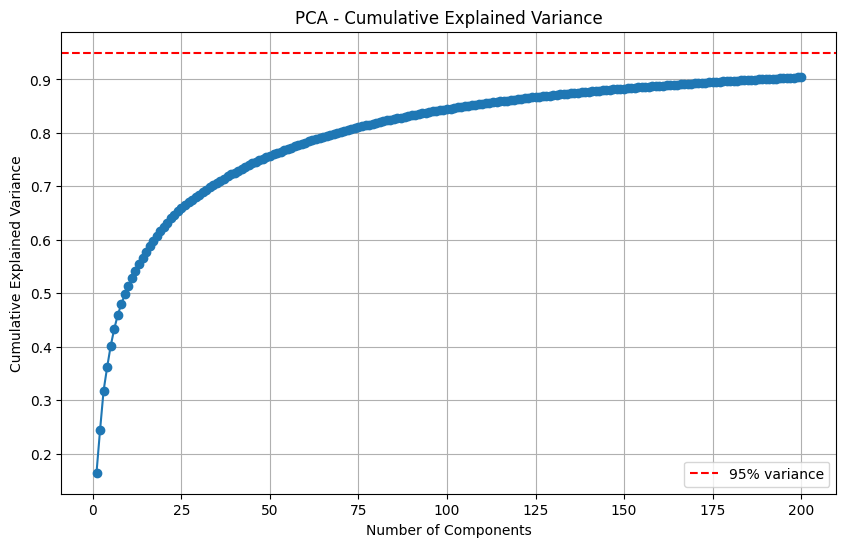

In [26]:
from sklearn.decomposition import PCA

pca = PCA(n_components=200)
pca.fit(X_train)

X_train_pca = pca.transform(X_train)
X_val_pca = pca.transform(X_val)

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Get explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Cumulative Explained Variance')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
plt.legend()
plt.show()

#### Training

Train Accuracy: 93.10%
Validation Accuracy: 85.71%
{'0': {'precision': 0.8220338983050848, 'recall': 0.9150943396226415, 'f1-score': 0.8660714285714286, 'support': 106.0}, '1': {'precision': 0.8214285714285714, 'recall': 0.8023255813953488, 'f1-score': 0.8117647058823529, 'support': 86.0}, '2': {'precision': 0.5487804878048781, 'recall': 0.5294117647058824, 'f1-score': 0.5389221556886228, 'support': 85.0}, '3': {'precision': 0.8484848484848485, 'recall': 0.9130434782608695, 'f1-score': 0.8795811518324608, 'support': 92.0}, '4': {'precision': 0.9026548672566371, 'recall': 0.8717948717948718, 'f1-score': 0.8869565217391304, 'support': 117.0}, '5': {'precision': 0.9605263157894737, 'recall': 0.8021978021978022, 'f1-score': 0.874251497005988, 'support': 91.0}, '6': {'precision': 0.7807017543859649, 'recall': 0.898989898989899, 'f1-score': 0.8356807511737089, 'support': 99.0}, '7': {'precision': 0.8160919540229885, 'recall': 0.7319587628865979, 'f1-score': 0.7717391304347826, 'support': 97.

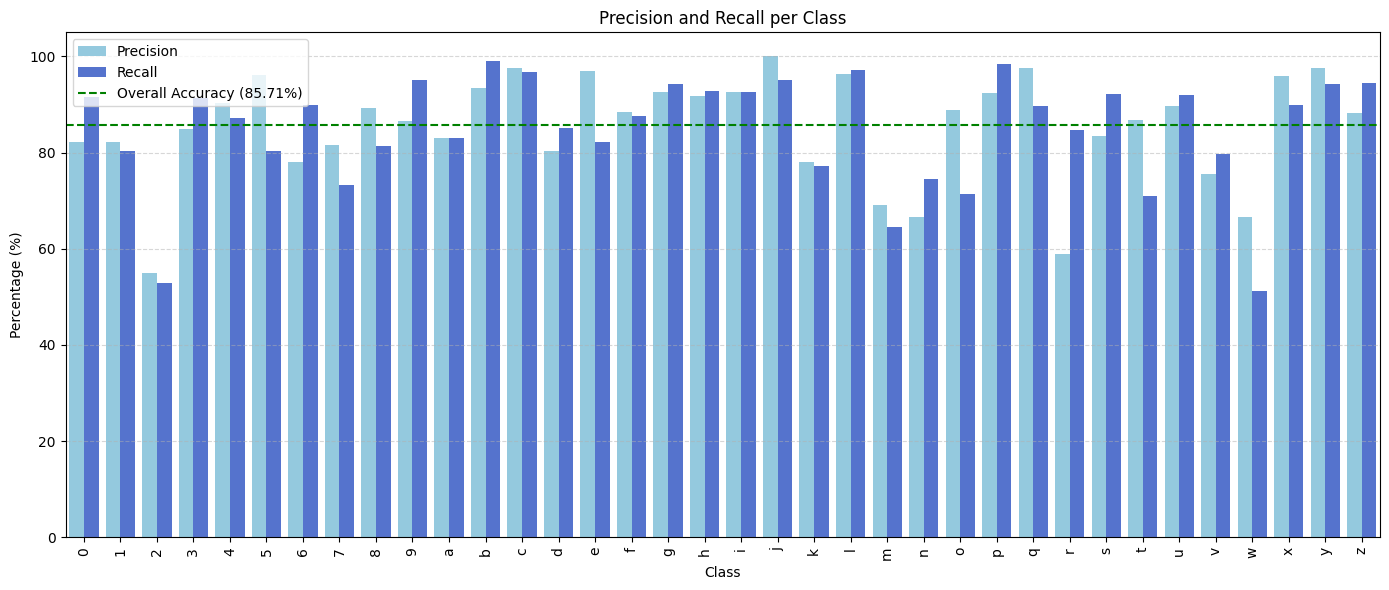

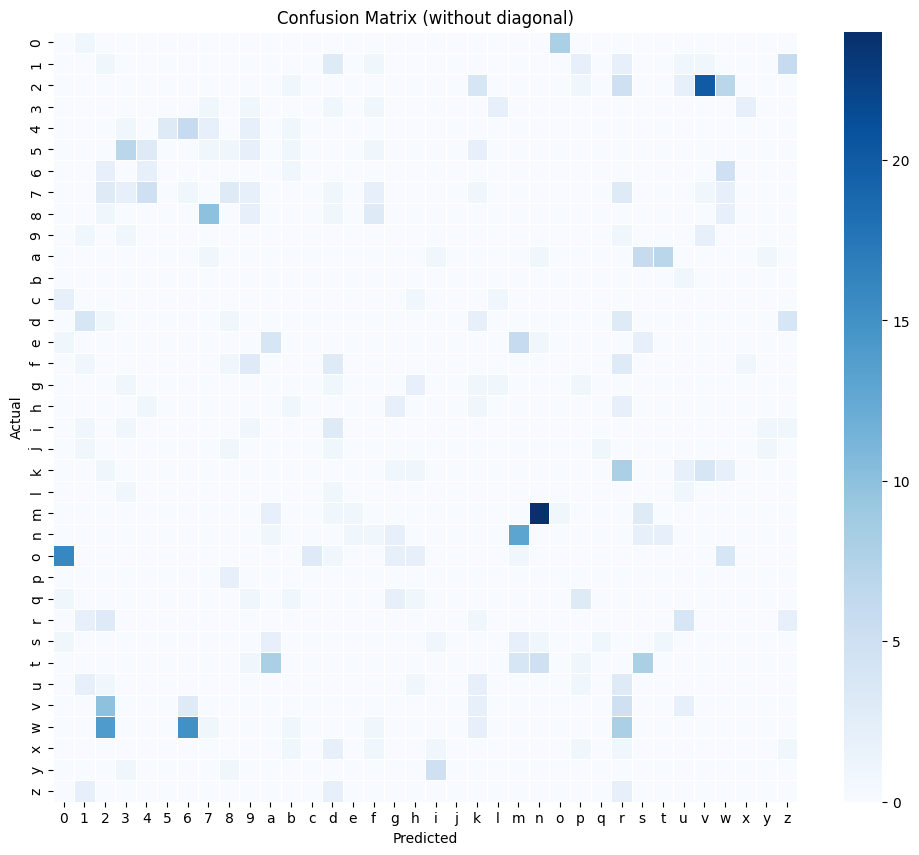

In [ ]:
import pandas as pd

# 4. Train SVM
svm = SVC(C=6, kernel="poly", gamma=0.01, degree=3, coef0=1, decision_function_shape="ovo")
svm.fit(X=X_train_pca, y=y_train)

# 5. Evaluate
y_pred_train = svm.predict(X_train_pca)
acc_train = accuracy_score(y_train, y_pred_train)
print(f"Train Accuracy: {acc_train:.2%}")

y_pred = svm.predict(X_val_pca)
acc = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {acc:.2%}")
report = classification_report(y_val, y_pred, target_names=CLASS_NAMES, output_dict=True)
print(report)

# Generate classification report
report_dict = classification_report(y_val, y_pred, target_names=CLASS_NAMES, output_dict=True)
overall_accuracy = accuracy_score(y_val, y_pred)

# Build DataFrame for precision and recall
data = {
    'Class': CLASS_NAMES,
    'Precision': [report_dict[label]['precision'] * 100 for label in CLASS_NAMES],
    'Recall': [report_dict[label]['recall'] * 100 for label in CLASS_NAMES]
}

df = pd.DataFrame(data)
df_melted = df.melt(id_vars='Class', var_name='Metric', value_name='Score')

# Plot using seaborn
plt.figure(figsize=(14, 6))
sns.barplot(data=df_melted, x='Class', y='Score', hue='Metric', palette=['skyblue', 'royalblue'])

# Add overall accuracy line
plt.axhline(overall_accuracy * 100, color='green', linestyle='--', label=f'Overall Accuracy ({overall_accuracy:.2%})')

# Customize
plt.title('Precision and Recall per Class')
plt.ylabel('Percentage (%)')
plt.ylim(0, 105)
plt.xticks(rotation=90)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 6. Confusion Matrix (optional)
cm = confusion_matrix(y_val, y_pred)
np.fill_diagonal(cm, 0)  # Zero out diagonal to highlight errors

plt.figure(figsize=(12, 10))
sns.heatmap(cm, xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            annot=False, cmap="Blues", linewidths=0.5)
plt.title("Confusion Matrix (without diagonal)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

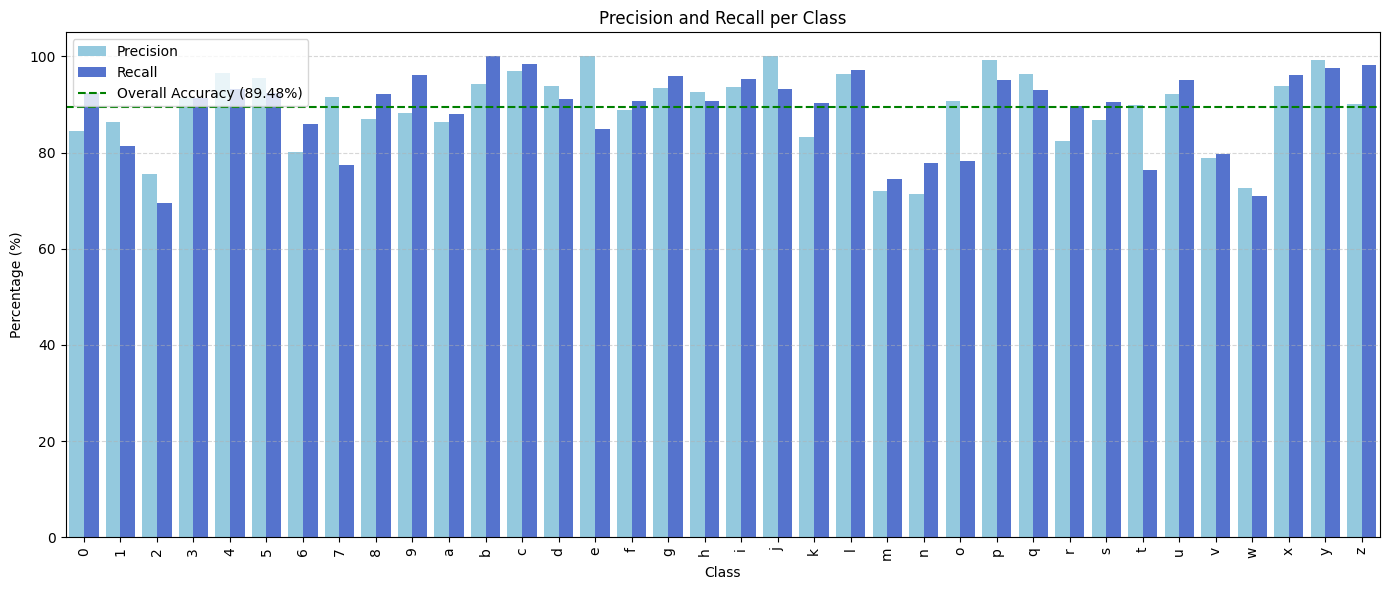

In [33]:
report_dict = classification_report(y_val, y_pred, target_names=CLASS_NAMES, output_dict=True)
overall_accuracy = accuracy_score(y_val, y_pred)

# Build DataFrame for precision and recall
data = {
    'Class': CLASS_NAMES,
    'Precision': [report_dict[label]['precision'] * 100 for label in CLASS_NAMES],
    'Recall': [report_dict[label]['recall'] * 100 for label in CLASS_NAMES]
}

df = pd.DataFrame(data)
df_melted = df.melt(id_vars='Class', var_name='Metric', value_name='Score')

# Plot using seaborn
plt.figure(figsize=(14, 6))
sns.barplot(data=df_melted, x='Class', y='Score', hue='Metric', palette=['skyblue', 'royalblue'])

# Add overall accuracy line
plt.axhline(overall_accuracy * 100, color='green', linestyle='--', label=f'Overall Accuracy ({overall_accuracy:.2%})')

# Customize
plt.title('Precision and Recall per Class')
plt.ylabel('Percentage (%)')
plt.ylim(0, 105)
plt.xticks(rotation=90)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

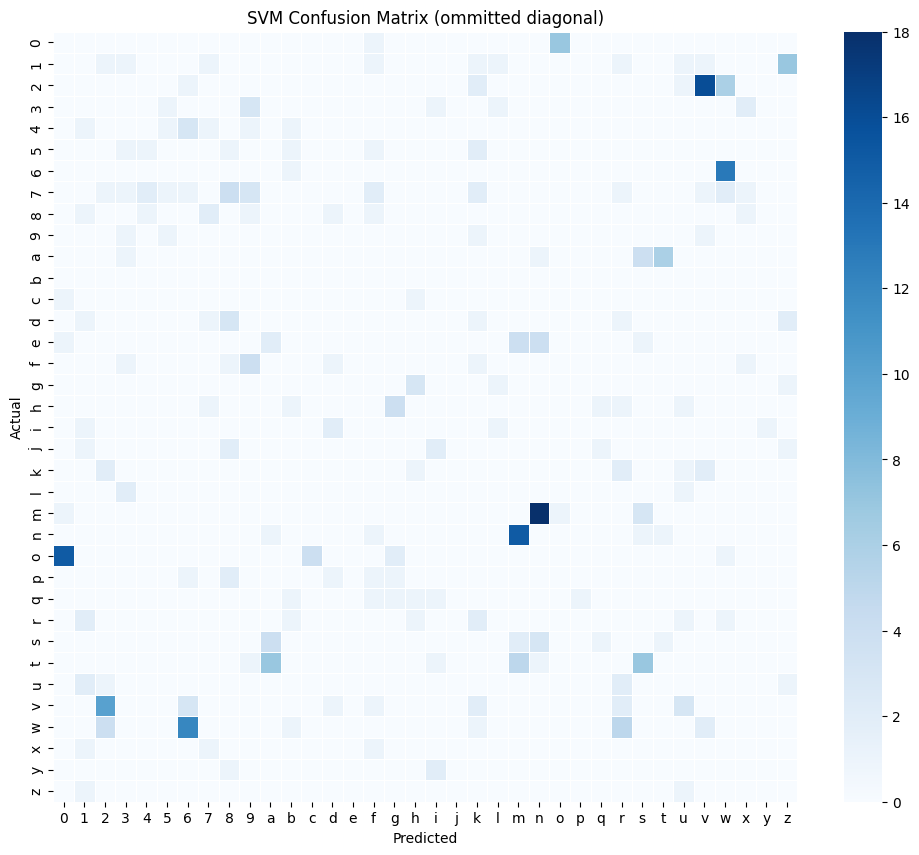

In [30]:
cm = confusion_matrix(y_val, y_pred)
np.fill_diagonal(cm, 0)  # Zero out diagonal to highlight errors

plt.figure(figsize=(12, 10))
sns.heatmap(cm, xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            annot=False, cmap="Blues", linewidths=0.5)
plt.title("SVM Confusion Matrix (ommitted diagonal)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#### Grid Search

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best params: {'kernel': 'poly', 'gamma': 0.021544346900318822, 'degree': 3, 'decision_function_shape': 'ovo', 'coef0': 1, 'C': 0.03593813663804628}
Best accuracy: 0.771374177916234
Validation Accuracy: 88.48%
              precision    recall  f1-score   support

           0       0.84      0.91      0.87       106
           1       0.84      0.81      0.83        86
           2       0.73      0.68      0.71        85
           3       0.92      0.90      0.91        92
           4       0.92      0.94      0.93       117
           5       0.97      0.92      0.94        91
           6       0.79      0.82      0.81        99
           7       0.91      0.75      0.82        97
           8       0.86      0.88      0.87       102
           9       0.90      0.95      0.92       102
           a       0.90      0.84      0.87       100
           b       0.93      0.99      0.96       114
           c       0.96    

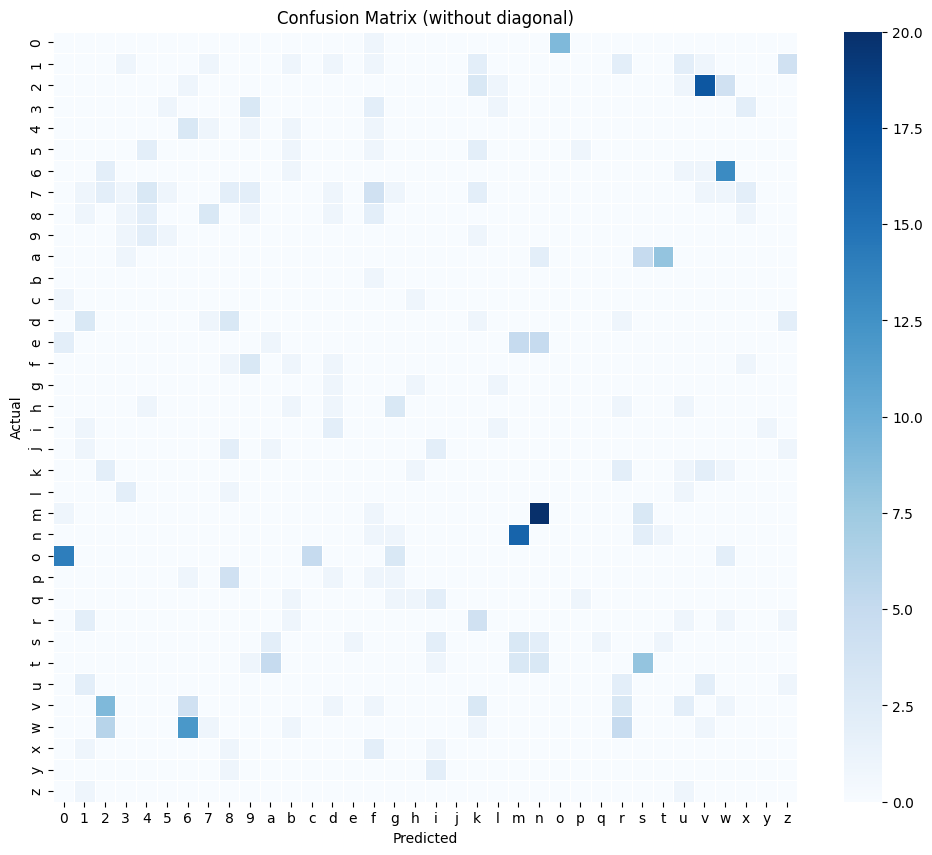

In [21]:
from sklearn.model_selection import RandomizedSearchCV

# 4. Train SVM
param_grid = {
    'C': np.logspace(-2, 3, 10),
    'gamma': np.logspace(-4, -1, 10),
    'kernel': ['rbf'],
}

param_grid = [
    {
        'C': np.logspace(-2, 3, 10),
        'gamma': np.logspace(-4, -1, 10),
        'kernel': ['rbf'],
        'decision_function_shape': ["ovo"]
    },
    {
        'kernel': ['linear'],
        'C': np.logspace(-2, 3, 10),
        'decision_function_shape': ["ovo"]
    },
    {
        'kernel': ['poly'],
        'C': np.logspace(-2, 3, 10),
        'gamma': np.logspace(-4, -1, 10),
        'degree': [2, 3, 4],  # common degrees
        'coef0': [0, 1],       # optional, especially useful for poly
        'decision_function_shape': ["ovo"]
    },
]

grid_search = RandomizedSearchCV(SVC(), param_grid, n_iter=20, scoring='accuracy', cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train_pca, y_train)

print("Best params:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)

svm = grid_search.best_estimator_

# 5. Evaluate
y_pred = svm.predict(X_val_pca)
acc = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {acc:.2%}")
print(classification_report(y_val, y_pred, target_names=CLASS_NAMES))

# 6. Confusion Matrix (optional)
cm = confusion_matrix(y_val, y_pred)
np.fill_diagonal(cm, 0)  # Zero out diagonal to highlight errors

plt.figure(figsize=(12, 10))
sns.heatmap(cm, xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            annot=False, cmap="Blues", linewidths=0.5)
plt.title("Confusion Matrix (without diagonal)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [29]:
import joblib

joblib.dump(svm, "svm_random_search.pkl")
# joblib.load("svm_random_search.pkl")

['svm_random_search.pkl']

### Grid Search Results

In [22]:
import pandas as pd

# Convert results to a DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Show key columns
results_df = results_df.sort_values(by='rank_test_score')
results_df = results_df[['rank_test_score', 'mean_test_score', 'params']]

# Display nicely
from IPython.display import display
display(results_df)
results_df.to_csv("grid_search_svm_results.csv", index=False)

,rank_test_score,mean_test_score,params
11,1,0.771374,"{'kernel': 'poly', 'gamma': 0.0215443469003188..."
13,2,0.757113,"{'kernel': 'poly', 'gamma': 0.1, 'degree': 3, ..."
15,3,0.730183,"{'kernel': 'poly', 'gamma': 0.01, 'degree': 2,..."
18,4,0.729007,"{'kernel': 'poly', 'gamma': 0.0215443469003188..."
19,5,0.438352,"{'kernel': 'linear', 'decision_function_shape'..."
14,6,0.409623,"{'kernel': 'rbf', 'gamma': 0.00046415888336127..."
17,7,0.406404,"{'kernel': 'linear', 'decision_function_shape'..."
16,8,0.406196,"{'kernel': 'rbf', 'gamma': 0.02154434690031882..."
4,9,0.361613,"{'kernel': 'poly', 'gamma': 0.0046415888336127..."
3,10,0.323884,"{'kernel': 'poly', 'gamma': 0.0021544346900318..."


In [24]:
import pandas as pd

# Load both result files
df_poly = pd.read_csv("./grid_search_svm_results.csv")
df_rbf = pd.read_csv("./docs/svm/svm_random_search.csv")

# Combine both into one DataFrame
combined = pd.concat([df_poly, df_rbf], ignore_index=True)

# Sort by mean_test_score descending
combined = combined.sort_values(by="mean_test_score", ascending=False)

# Re-rank
combined["rank_test_score"] = range(1, len(combined) + 1)

# Reorder columns
combined = combined[["rank_test_score", "mean_test_score", "params"]]

# Save to CSV
combined.to_csv("combined_ranked_results.csv", index=False)